# How to build a multi-agent network

!!! info "Prerequisites"
    This guide assumes familiarity with the following:
  
    - [Command](../../concepts/low_level/#command)
    - [Multi-agent systems](../../concepts/multi_agent)


In this how-to guide we will build a simple case of a [multi-agent network](../../concepts/multi_agent#network) architecture. We will create a team of [non-player characters (NPCs)](https://en.wikipedia.org/wiki/Non-player_character) that all run at the same time and share game state (resources). At each step, each NPC will inspect the state and decide whether to halt or continue acting at the next step. If it continues, it will update the shared game state (produce or consume resources).

To do so, the agent nodes will return `Command` object that allows you to [combine both control flow and state updates](../command):

```python
def character(state: GameState) -> Command[Literal["character"]]:
    # the condition for halting/continuation can be anything, e.g. LLM tool call / structured output, etc.
    ...
    if not should_halt:
        return Command(goto="character", update={"my_state_key": "my_state_value"})
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define graph

We will create 4 NPC agents:

- `villager`: produces wood and food until there is enough, then halts
- `guard`: protects gold and consumes food. When there is not enough food, leaves duty and halts
- `merchant`: trades wood for gold. When there is not enough wood, halts
- `thief`: checks if the guard is on duty and steals all of the gold when the guard leaves, then halts

Our NPC agents will be simple node functions (`villager`, `guard`, etc.). At each step of the graph execution, the agent function will inspect the resource values in the state and decide whether it should halt or continue. If it decides to continue, it will update the resource values in the state and loop back to itself to run at the next step.

Now, let's define our agent nodes and graph!

In [78]:
from typing_extensions import Annotated, TypedDict, Literal

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START
from langgraph.types import Command

import operator


class GameState(TypedDict):
    # note that we're defining a reducer (operator.add) here.
    # This will allow all agents to write their updates for resources concurrently.
    wood: Annotated[int, operator.add]
    food: Annotated[int, operator.add]
    gold: Annotated[int, operator.add]
    guard_on_duty: bool


def villager(state: GameState) -> Command[Literal["villager"]]:
    """Villager NPC that gathers wood and food."""
    current_resources = state["wood"] + state["food"]
    if current_resources < 15:  # Continue gathering until we have enough resources
        print(f'Villager gathering resources.')
        return Command(
            goto="villager",
            update={"wood": 3, "food": 1}
        )

def guard(state: GameState) -> Command[Literal["guard"]]:
    """Guard NPC that protects gold and consumes food."""
    if not state["guard_on_duty"]:
        return
    
    if state["food"] > 0:  # Guard needs food to keep patrolling
        print(f'Guard patrolling.')
        return Command(
            goto="guard",
            update={"food": -1}  # Consume food while patrolling
        )
    else:
        print(f'Guard leaving to get food.')
        return Command(update={"guard_on_duty": False})  # Leave to get food

def merchant(state: GameState) -> Command[Literal["merchant"]]:
    """Merchant NPC that trades wood for gold."""
    if state["wood"] >= 5:  # Trade wood for gold when available
        print(f'Merchant trading wood for gold.')
        return Command(
            goto="merchant",
            update={"wood": -5, "gold": 1}
        )

def thief(state: GameState) -> Command[Literal["thief"]]:
    """Thief NPC that steals gold if the guard leaves to get food."""
    if not state["guard_on_duty"]:
        print(f'Thief stealing gold.')
        return Command(update={"gold": -state["gold"]})
    else:
        # keep thief on standby
        return Command(goto="thief")

builder = StateGraph(GameState)

# Add NPC nodes
builder.add_node(villager)
builder.add_node(guard)
builder.add_node(merchant)
builder.add_node(thief)

# All NPCs start running in parallel
builder.add_edge(START, "villager")
builder.add_edge(START, "guard")
builder.add_edge(START, "merchant")
builder.add_edge(START, "thief")
graph = builder.compile()

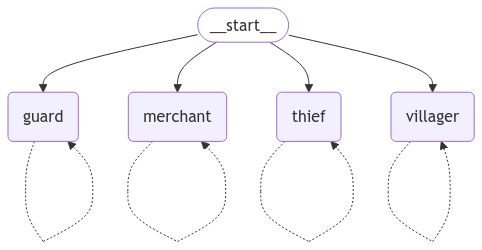

In [79]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Let's run it with some initial state!

In [80]:
initial_state = {
    "wood": 10,
    "food": 3,
    "gold": 10,
    "guard_on_duty": True
}
for state in graph.stream(initial_state, stream_mode="values"):
    print("Game state", state)
    print("\n")

Game state {'wood': 10, 'food': 3, 'gold': 10, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Merchant trading wood for gold.
Game state {'wood': 8, 'food': 3, 'gold': 11, 'guard_on_duty': True}


Guard patrolling.
Merchant trading wood for gold.
Villager gathering resources.
Game state {'wood': 6, 'food': 3, 'gold': 12, 'guard_on_duty': True}


Guard patrolling.
Merchant trading wood for gold.
Villager gathering resources.
Game state {'wood': 4, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Villager gathering resources.
Guard patrolling.
Game state {'wood': 7, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Villager gathering resources.
Game state {'wood': 10, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Villager gathering resources.
Game state {'wood': 13, 'food': 3, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Game state {'wood': 13, 'food': 2, 'gold': 13, 'guard_on_duty': True}


Guard patrolling.
Game sta